## DataFrame benchmarks with object vs. string[pyarrow] data

In [59]:
import dask
dask.utils.show_versions()

{
  "Python": "3.11.0",
  "Platform": "Darwin",
  "dask": "2023.3.2",
  "distributed": "2023.3.2",
  "numpy": "1.24.2",
  "pandas": "2.0.0rc1",
  "cloudpickle": "2.2.1",
  "fsspec": "2023.3.0",
  "bokeh": "2.4.3",
  "fastparquet": null,
  "pyarrow": "11.0.0",
  "zarr": null
}

In [60]:
import pandas as pd
import numpy as np
from dask.sizeof import sizeof
from dask.utils import format_bytes
from dask import delayed
import dask.dataframe as dd
import random
import string
from distributed import wait
from distributed import Client
from distributed.diagnostics import MemorySampler
import coiled
import matplotlib
import matplotlib.pyplot as plt

In [61]:
from dask.distributed import performance_report

In [62]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
cluster

LocalCluster(12abb1e8, 'tcp://127.0.0.1:59905', workers=4, threads=12, memory=64.00 GiB)

In [63]:
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59905,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:59919,Total threads: 3
Dashboard: http://127.0.0.1:59921/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:59908,


In [64]:
# partitions in the generated dataframe
npartitions = 50

In [65]:
n = 10_000
names = [
    "".join(random.choices(string.ascii_letters + string.digits + " ", k=random.randint(10, 100)))
    for _ in range(n)
] 

@delayed(pure=False)
def make_partition(dtype):
    nrows = 1_000_000
    data = [random.choice(names) for _ in range(nrows)]
    df = pd.DataFrame({"name": pd.Series(data, dtype=dtype)})
    return df

In [66]:
def get_ddf(persist=False):
    meta = pd.DataFrame({"name": pd.Series([], dtype=object)})
    ddf = dd.from_delayed(
        [make_partition(object) for i in range(npartitions)],
        meta=meta
    )
    return ddf.persist() if persist else ddf

In [67]:
def get_ddf2(persist=False):
    meta = pd.DataFrame({"name": pd.Series([], dtype="string[pyarrow]")})
    ddf = dd.from_delayed(
        [make_partition("string[pyarrow]") for i in range(npartitions)],
        meta=meta
    )
    return ddf.persist() if persist else ddf

## Memory usage

In [70]:
from dask.utils import format_bytes

In [71]:
ddf = get_ddf(True)

In [72]:
ddf.size.compute()

50000000

In [73]:
ddf.dtypes

name    object
dtype: object

In [74]:
ddf.head(10)

,name
0,IqmYv3ZoE0NZl1PHyIhkXUwqVePYuBVisQraFyAXepi6BC...
1,XE4KLPN6istM312ehCT2G1Rl9tllAgUgv
2,Nk1Nau7SC37 KW6sewRk87f21nMNUyXDvsp1 pZ0QQKfR6...
3,PQQ6PikvUDryu5wCDkvg
4,MhoU2WbL5l18Zu1OKYUZ8hGn0VbA
5,8 5opcWh3Xa9duAmFOV7XYurRNF66iVWnCWwS6AKsP6D4y...
6,mJS24x5cHzyhB1FdnwAl dGauzOJ80A1K9fEg RgNo3ULQ...
7,yQcvkw6zy2fqSY3NglXkPIuoYAfO4am0dKu1oL2i9dUavZ...
8,ccJlnUXrYxZjD9CmJxdtZtLuxbrTSj CJbb g7x32IqBVf...
9,63HlDri xvgPKYvh0PSMaHl


In [75]:
format_bytes(ddf.memory_usage(deep=True).sum().compute())

'5.20 GiB'

In [76]:
memory_usage_object = ddf.memory_usage_per_partition(deep=True).compute().apply(format_bytes)
memory_usage_object

0     106.49 MiB
1     106.46 MiB
2     106.50 MiB
3     106.46 MiB
4     106.52 MiB
5     106.48 MiB
6     106.51 MiB
7     106.47 MiB
8     106.43 MiB
9     106.51 MiB
10    106.45 MiB
11    106.48 MiB
12    106.46 MiB
13    106.44 MiB
14    106.43 MiB
15    106.51 MiB
16    106.42 MiB
17    106.46 MiB
18    106.52 MiB
19    106.45 MiB
20    106.48 MiB
21    106.44 MiB
22    106.44 MiB
23    106.47 MiB
24    106.51 MiB
25    106.51 MiB
26    106.48 MiB
27    106.46 MiB
28    106.49 MiB
29    106.45 MiB
30    106.45 MiB
31    106.47 MiB
32    106.51 MiB
33    106.42 MiB
34    106.53 MiB
35    106.50 MiB
36    106.50 MiB
37    106.45 MiB
38    106.46 MiB
39    106.45 MiB
40    106.50 MiB
41    106.43 MiB
42    106.49 MiB
43    106.48 MiB
44    106.51 MiB
45    106.43 MiB
46    106.42 MiB
47    106.50 MiB
48    106.45 MiB
49    106.51 MiB
dtype: object

In [17]:
ddf2 = get_ddf2(True)

In [18]:
ddf2.dtypes

name    string[pyarrow]
dtype: object

In [19]:
format_bytes(ddf2.memory_usage(deep=True).sum().compute())

'2.73 GiB'

In [20]:
memory_usage_string = ddf2.memory_usage_per_partition().compute().apply(format_bytes)
memory_usage_string

0     55.95 MiB
1     55.91 MiB
2     55.95 MiB
3     55.92 MiB
4     55.97 MiB
5     55.97 MiB
6     55.98 MiB
7     55.90 MiB
8     55.93 MiB
9     55.96 MiB
10    55.96 MiB
11    55.96 MiB
12    55.95 MiB
13    55.97 MiB
14    55.94 MiB
15    55.92 MiB
16    55.94 MiB
17    55.90 MiB
18    55.94 MiB
19    55.92 MiB
20    55.93 MiB
21    55.96 MiB
22    55.95 MiB
23    55.92 MiB
24    55.94 MiB
25    55.92 MiB
26    55.98 MiB
27    55.93 MiB
28    55.96 MiB
29    55.94 MiB
30    55.93 MiB
31    55.96 MiB
32    55.92 MiB
33    55.94 MiB
34    55.90 MiB
35    55.90 MiB
36    55.95 MiB
37    55.96 MiB
38    55.92 MiB
39    55.89 MiB
40    55.92 MiB
41    55.93 MiB
42    55.92 MiB
43    55.97 MiB
44    55.91 MiB
45    55.96 MiB
46    55.92 MiB
47    55.95 MiB
48    55.91 MiB
49    55.98 MiB
dtype: object

## Running time

In [40]:
client.restart();

2023-03-30 11:59:18,455 - distributed.nanny - WARNING - Restarting worker
2023-03-30 11:59:18,457 - distributed.nanny - WARNING - Restarting worker
2023-03-30 11:59:18,475 - distributed.nanny - WARNING - Restarting worker
2023-03-30 11:59:18,476 - distributed.nanny - WARNING - Restarting worker


In [41]:
ddf = get_ddf(True)

In [42]:
wait(ddf);

In [44]:
%timeit -r 5 -n 2 ddf.name.unique().compute()

The slowest run took 98.66 times longer than the fastest. This could mean that an intermediate result is being cached.
248 ms ± 228 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [45]:
%timeit -r 5 -n 2 ddf.groupby("name").count().compute()

The slowest run took 84.80 times longer than the fastest. This could mean that an intermediate result is being cached.
277 ms ± 250 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [46]:
%timeit -r 5 -n 2 ddf.name.str.startswith("a").compute()

1.9 s ± 19.8 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [48]:
%timeit -r 5 -n 2 ddf.name.str.len().compute()

2.03 s ± 7.22 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [49]:
client.restart();

2023-03-30 12:00:50,146 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:00:50,167 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:00:50,168 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:00:50,173 - distributed.nanny - WARNING - Restarting worker


In [50]:
ddf2 = get_ddf2(True)

In [51]:
wait(ddf2);

In [53]:
%timeit -r 5 -n 2 ddf2.name.unique().compute()

The slowest run took 24.02 times longer than the fastest. This could mean that an intermediate result is being cached.
79.1 ms ± 87 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [54]:
%timeit -r 5 -n 2 ddf2.groupby("name").count().compute()

396 ms ± 7.49 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [55]:
%timeit -r 5 -n 2 ddf2.name.str.startswith("a").compute()

263 ms ± 16.6 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [56]:
%timeit -r 5 -n 2 ddf2.name.str.len().compute()

698 ms ± 14.3 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


## Create memory samplers and store benchmarks

In [23]:
ms1 = MemorySampler()
ms2 = MemorySampler()
ms3 = MemorySampler()
ms4 = MemorySampler()

In [24]:
report_dir = "performance/local4workers2"

In [25]:
import time

## Benchmark 1

In [26]:
client.restart();

2023-03-30 12:10:09,199 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:09,210 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:09,211 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:09,212 - distributed.nanny - WARNING - Restarting worker


In [27]:
# 1
with performance_report(filename=f"{report_dir}/1-object-unique.html"):
    with ms1.sample("object string", interval=0.01):
        for _ in range(1):
            get_ddf(True).name.unique().compute()
            time.sleep(0.2)

In [28]:
client.restart();

2023-03-30 12:10:17,641 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:17,652 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:17,653 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:17,654 - distributed.nanny - WARNING - Restarting worker


In [29]:
# 1, ddf2
with performance_report(filename=f"{report_dir}/1-string-unique.html"):
    with ms1.sample("arrow string", interval=0.01):
        for _ in range(1):
            get_ddf2(True).name.unique().compute()
            time.sleep(0.2)

<Axes: title={'center': 'Unique'}, xlabel='time', ylabel='Cluster memory (GiB)'>

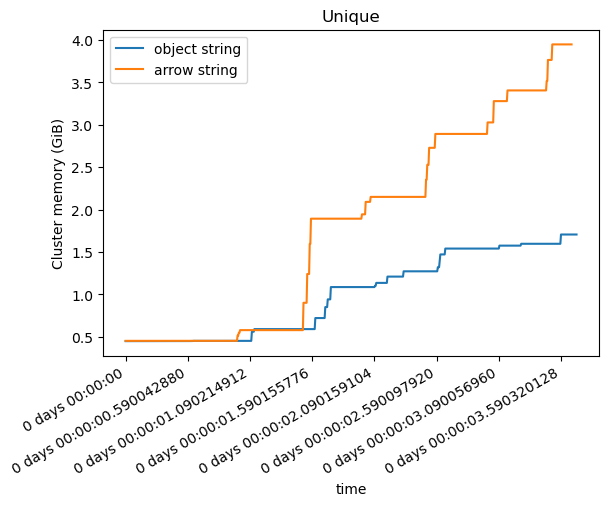

In [30]:
ms1.plot(align=True, title="Unique")

## Benchmark 2

In [31]:
client.restart();

2023-03-30 12:10:31,476 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:31,501 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:31,510 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:31,511 - distributed.nanny - WARNING - Restarting worker


In [32]:
# 2
with performance_report(filename=f"{report_dir}/2-object-group-count.html"):
    with ms2.sample("object string", interval=0.01):
        for _ in range(1):
            get_ddf(True).groupby("name").count().compute()
            time.sleep(0.2)

In [33]:
client.restart();

2023-03-30 12:10:40,845 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:40,866 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:40,867 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:10:40,868 - distributed.nanny - WARNING - Restarting worker


In [34]:
# 2, ddf2
with performance_report(filename=f"{report_dir}/2-string-group-count.html"):
    with ms2.sample("arrow string", interval=0.01):
        for _ in range(1):
            get_ddf2(True).groupby("name").count().compute()
            time.sleep(0.2)

<Axes: title={'center': 'Groupby/count'}, xlabel='time', ylabel='Cluster memory (GiB)'>

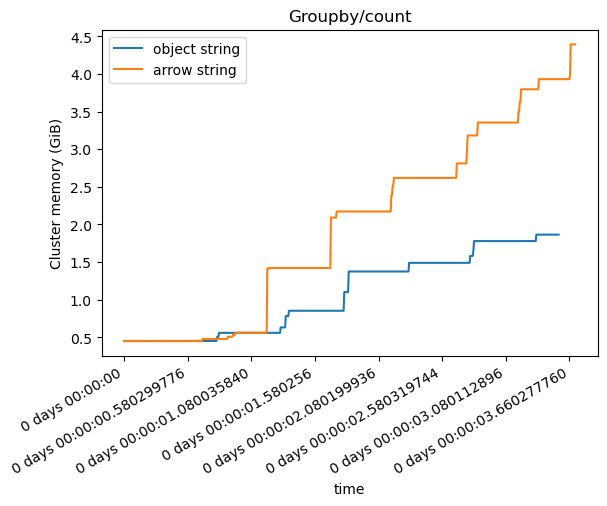

In [35]:
ms2.plot(align=True, title="Groupby/count")

## Benchmark 3

In [44]:
client.restart();

2023-03-30 12:49:27,077 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:49:27,090 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:49:27,092 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:49:27,100 - distributed.nanny - WARNING - Restarting worker


In [45]:
# 3
with performance_report(filename=f"{report_dir}/3-object-startswith.html"):
    with ms3.sample("object string", interval=0.01):
        for _ in range(1):
            get_ddf(True).name.str.startswith("a").compute()
            time.sleep(0.2)

In [46]:
client.restart();

2023-03-30 12:50:11,198 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:50:11,216 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:50:11,217 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:50:11,218 - distributed.nanny - WARNING - Restarting worker


In [47]:
# 3, ddf2
with performance_report(filename=f"{report_dir}/3-string-startswith.html"):
    with ms3.sample("arrow string", interval=0.01):
        for _ in range(1):
            get_ddf2(True).name.str.startswith("a").compute()
            time.sleep(0.2)

<Axes: title={'center': 'String startswith'}, xlabel='time', ylabel='Cluster memory (GiB)'>

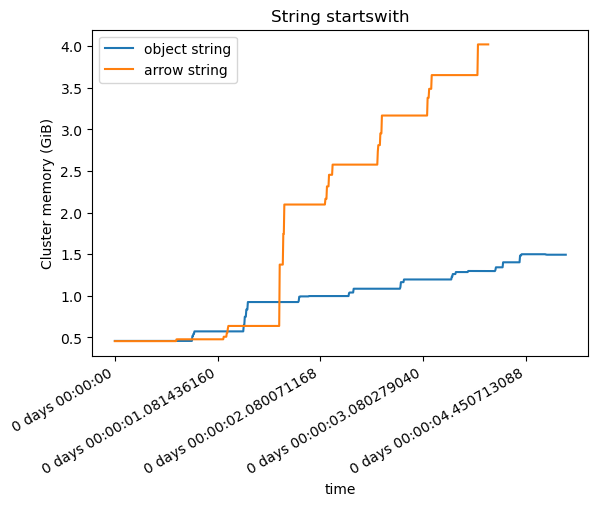

In [48]:
ms3.plot(align=True, title="String startswith")

## Benchmark 4

In [51]:
client.restart();

2023-03-30 12:50:40,011 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:50:40,035 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:50:40,036 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:50:40,037 - distributed.nanny - WARNING - Restarting worker


In [52]:
# 4
with performance_report(filename=f"{report_dir}/4-object-strlen.html"):
    with ms4.sample("object string", interval=0.01):
        for _ in range(1):
            get_ddf(True).name.str.len().compute()
            time.sleep(0.2)

In [54]:
client.restart();

2023-03-30 12:51:07,062 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:51:07,092 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:51:07,093 - distributed.nanny - WARNING - Restarting worker
2023-03-30 12:51:07,094 - distributed.nanny - WARNING - Restarting worker


In [55]:
# 4, ddf2
with performance_report(filename=f"{report_dir}/4-string-strlen.html"):
    with ms4.sample("arrow string", interval=0.01):
        for _ in range(1):
            get_ddf2().name.str.len().compute()
            time.sleep(0.2)

<Axes: title={'center': 'String length'}, xlabel='time', ylabel='Cluster memory (GiB)'>

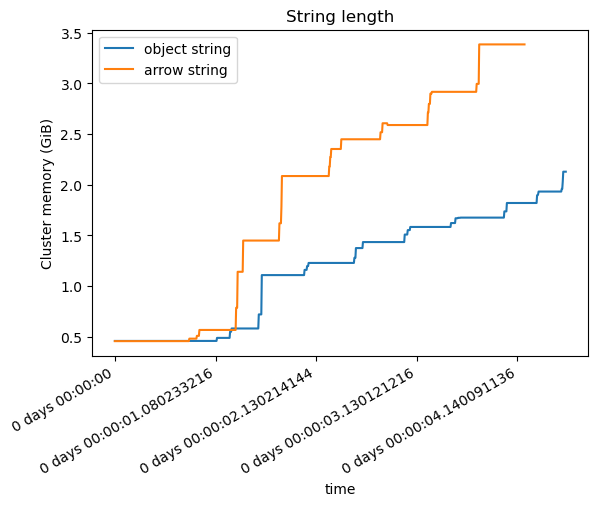

In [56]:
ms4.plot(align=True, title="String length")

In [57]:
client.close()

In [58]:
cluster.close()